In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import scipy.io as io
import helper as hp
import importlib
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from IPython.display import Audio, update_display
from ipywidgets import IntProgress
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importo respuestas impulsivas de BOSE QC20

In [4]:
elecBackITA = io.loadmat("./PANDAR_database_1.0/BoseQC20/electronic_backend/PANDAR_TF_201_backend_dSPACE.ita")
acousticPathsITA = io.loadmat("./PANDAR_database_1.0/BoseQC20/acoustic_booth/persons/PANDAR_TF_001_person_BoseQC20.ita")

fs = 48000

In [5]:
elecBack = elecBackITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][14].T        # Direct, Lowcut, AAF, PreAmp En este orden estan las resp impulsivas

display(elecBackITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][16])
display(elecBack.shape)

array([[array(['Direct'], dtype='<U6')],
       [array(['LowCut'], dtype='<U6')],
       [array(['AAF'], dtype='<U3')],
       [array(['Preamp'], dtype='<U6')]], dtype=object)

(4, 8192)

In [6]:
acousticPaths = acousticPathsITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][14].T   # SecL, SecR, FeedBL, FeedBR, primL, PrimR

acousticPathsITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][16]

array([[array(['SecondaryL'], dtype='<U10')],
       [array(['SecondaryR'], dtype='<U10')],
       [array(['FeedbackL'], dtype='<U9')],
       [array(['FeedbackR'], dtype='<U9')],
       [array(['PrimaryL'], dtype='<U8')],
       [array(['PrimaryR'], dtype='<U8')]], dtype=object)

# Genero el aparato experimental simulado

# Importo Algunas muestras de audio para utilizar como señal para querer escuchar

In [7]:
_, Voice = io.wavfile.read("Voice.wav")
_, Song = io.wavfile.read("Song.wav")

Song = Song.T


/tmp/ipykernel_37517/2875689267.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Voice = io.wavfile.read("Voice.wav")
/tmp/ipykernel_37517/2875689267.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Song = io.wavfile.read("Song.wav")
/tmp/ipykernel_37517/2875689267.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Street = io.wavfile.read("ruidoCalle.wav")


# Importo algunos sonidos para utilizar como interferencias

In [13]:
_, Street = io.wavfile.read("ruidoCalle.wav")
Street = Street.T

/tmp/ipykernel_37517/3237611321.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Street = io.wavfile.read("ruidoCalle.wav")


# Demos de FX-NLMS

## Zona de silencio con ruido blanco

En el siguiente bloque se formo una zona de silencio que elimina interferencias de ruido blanco. Se utilizo el mismo sistema para P y S, siendo este un filtro FIR pasabajos con frecuencia de corte en 15kHz.

Para un w de orden 10, se puede ver que el primer termino de este converge a -1, y los demas a 0.

In [15]:
x = lambda n: np.random.normal(0, 2, size=len(n))

sound = lambda n: 0

w_order = 10
wi = np.zeros(w_order)
mu = 0.5
P = ([0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )


S = ([ 0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )

S_hat = S

results = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)


IntProgress(value=0, max=384000)

2.9429972654360133e-24

<StemContainer object of 3 artists>

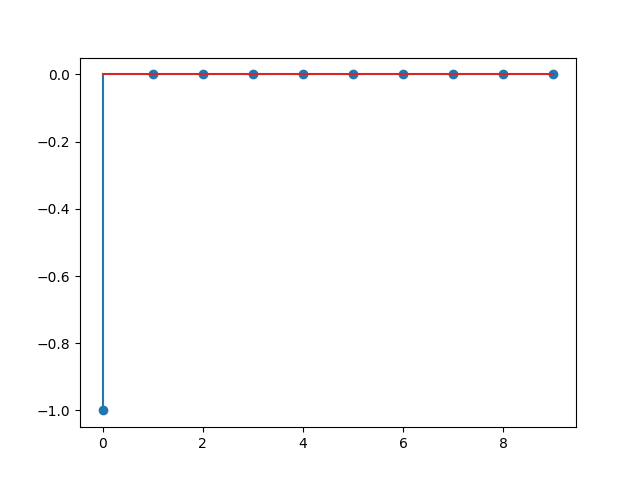

In [21]:
plt.figure()
plt.stem(results[0])

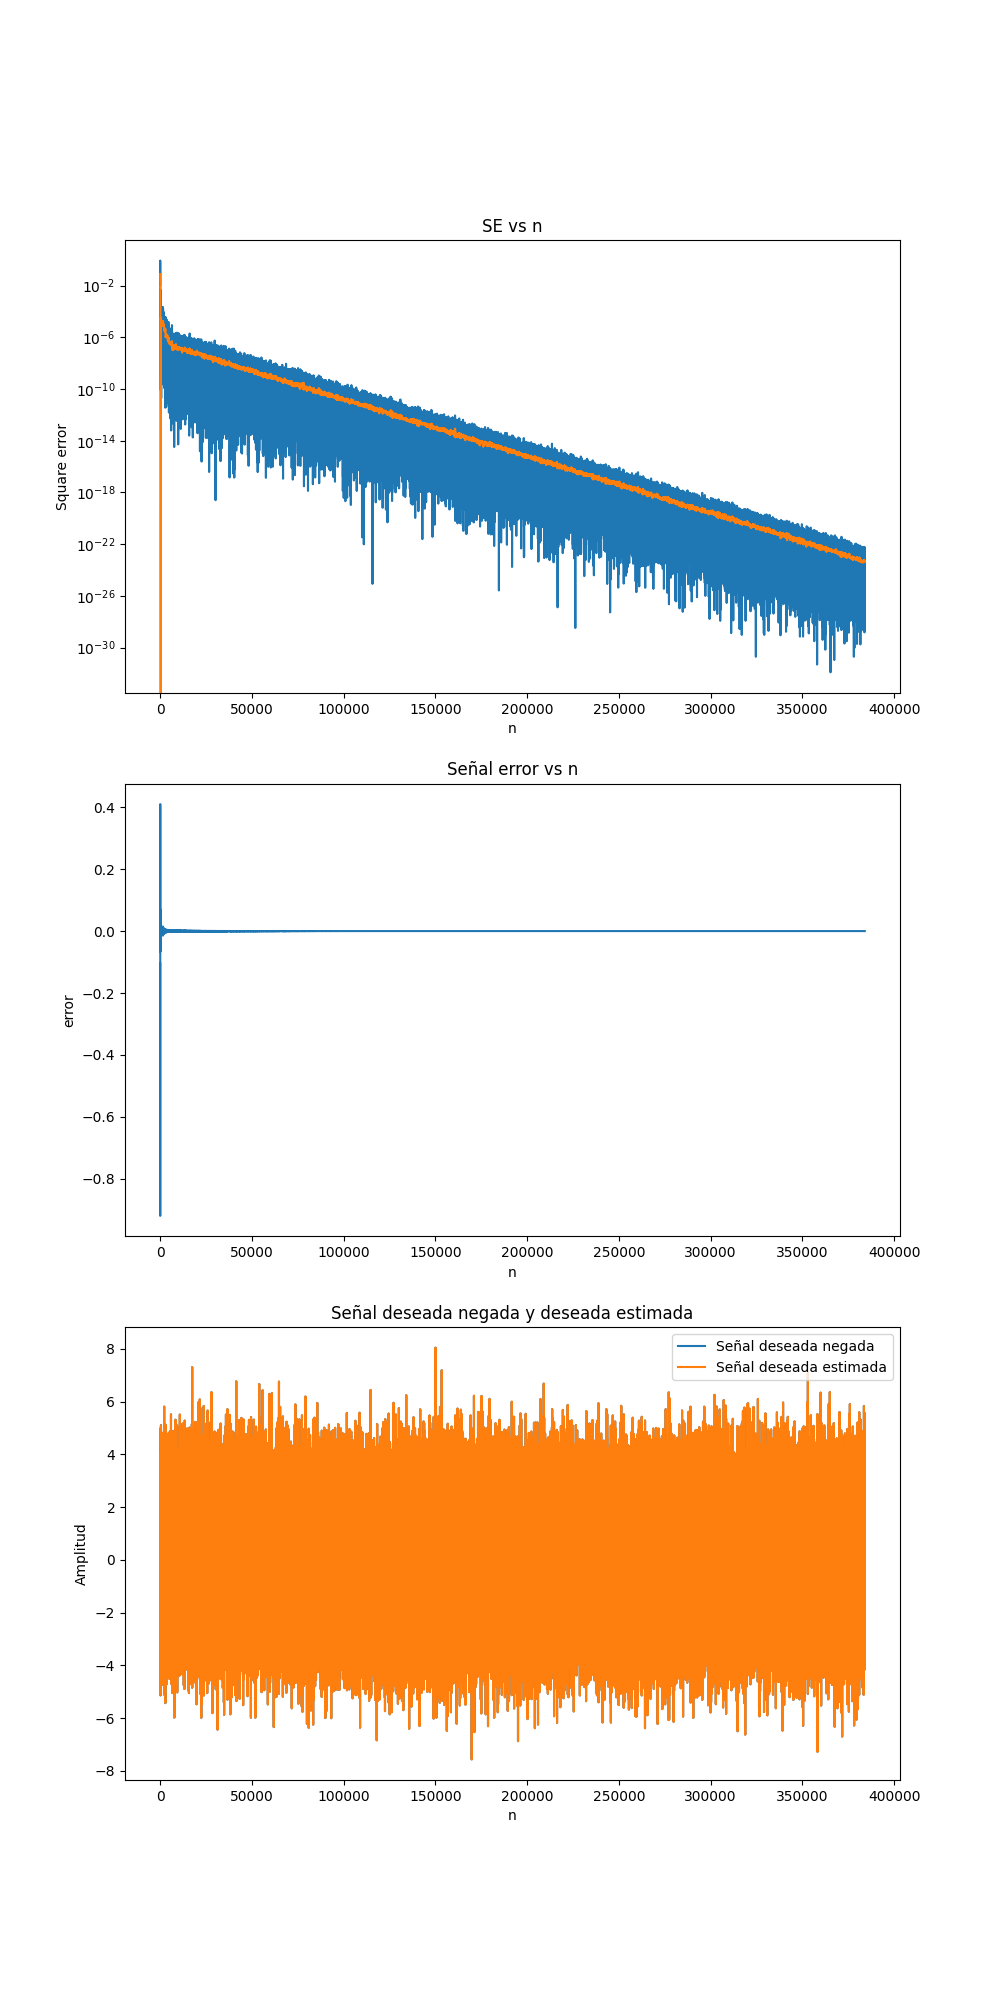

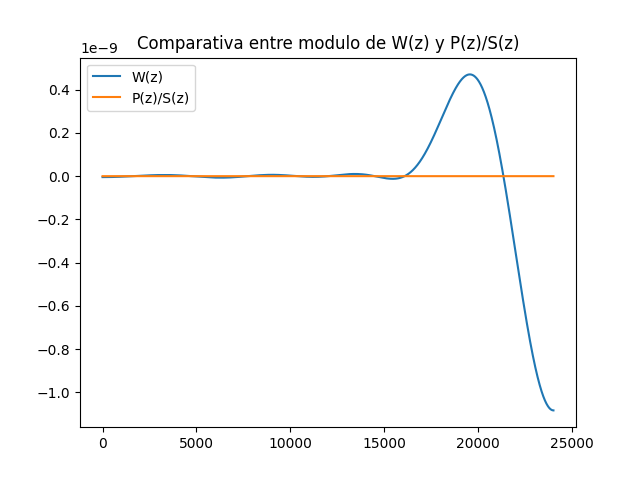

In [20]:
hp.plot_results(results, P, S)